# Homework 3: Visualizing Data with Movies

Name: 

Date: 

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [7]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import moviepy.video.io.ImageSequenceClip

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [8]:
# define the path to the data folder
data_folder = '/Users/misha/School Projects/Ocean Modeling/Data/'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [70]:
# read in the data
data_file = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily', 'SST', 'SST_20150101.nc')
ds = xr.open_dataset(data_file, decode_times=False)
print(ds)
longitude = np.array(ds['LONGITUDE_T'][:])
latitude = np.array(ds['LATITUDE_T'][:])
# sst = np.array(ds['sst'][:])
sst = np.array(ds['SST'][:])
# # #ds = nc4.Dataset(data_file, 'w')
# # logitude = np.array(ds.variable['longitude'][:])
# # latitude = np.array(ds.variable['latitude'][:])
# # sst = np.array(ds.variable['sst'][:])
ds.close()

<xarray.Dataset>
Dimensions:      (TIME: 1, LATITUDE_T: 720, LONGITUDE_T: 1440)
Coordinates:
  * TIME         (TIME) float32 8.402e+03
  * LATITUDE_T   (LATITUDE_T) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * LONGITUDE_T  (LONGITUDE_T) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    SST          (TIME, LATITUDE_T, LONGITUDE_T) float32 ...
Attributes:
    description:  ECCO LLC270 daily average


Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [71]:
# define the longitude/latitude bounds
min_lon = -105
max_lon = -75
min_lat = 15
max_lat = 35

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(longitude - (min_lon)))
max_row = np.argmin(np.abs(longitude - (max_lon)))
min_col = np.argmin(np.abs(latitude - (min_lat)))   
max_col = np.argmin(np.abs(latitude - (max_lat)))
print(min_row, max_row, min_col, max_col)

299 419 419 499


Use the row and column bounds to subset the longitude, latitude, and your variable:

In [74]:
# subset the data
print(sst.shape)
sst_subset = sst[0]
print(sst_subset.shape)
sst_subset = sst_subset[min_col:max_col , min_row:max_row]
print(sst_subset.shape)
 #sst_subset = sst_subset where data > 0
sst_subset = np.where(sst_subset > 0, sst_subset, np.nan)
longitude_subset = longitude[min_row:max_row]
latitude_subset = latitude[min_col:max_col]
# print(sst_subset.shape)
# print(longitude_subset.shape)
# print(latitude_subset.shape)



(1, 720, 1440)
(720, 1440)
(80, 120)


Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

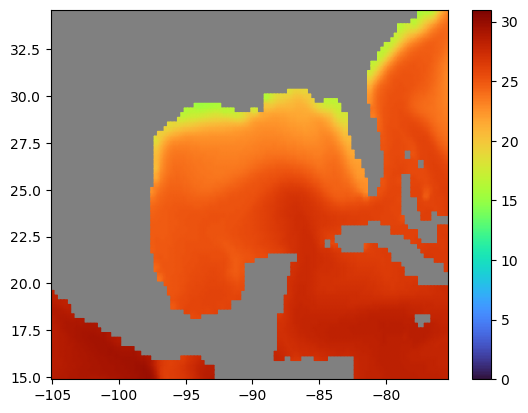

In [80]:
# make your figure here
fig = plt.figure()
plt.pcolormesh(longitude_subset, latitude_subset, sst_subset[:,:], cmap='turbo', vmin= 0, vmax= 31, shading='gouraud')
plt.colorbar()
plt.gca().set_facecolor('grey')




## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [111]:
plot_dir = '/Users/misha/School Projects/Ocean Modeling/HW3/plots'
def plot_panel(year,month,day):
    # fill in your function here
    plt.close('all')
    data_file = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily', 'SST', 'SST_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'.nc')
    ds = xr.open_dataset(data_file, decode_times=False)
    sst = np.array(ds['SST'][:])
    sst_subset = sst[0]
    sst_subset = sst_subset[min_col:max_col , min_row:max_row]
    sst_subset = np.where(sst_subset > 0, sst_subset, np.nan)
    plt.pcolormesh(longitude_subset, latitude_subset, sst_subset[:,:], cmap='turbo', vmin= 10, vmax= 35, shading='gouraud')
    plt.colorbar()
    plt.gca().set_facecolor('grey')
    month_name = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    plt.title('Sea Surface Temperature '+month_name[month-1]+' '+str(day).zfill(2)+', '+str(year))
    plt.savefig(os.path.join(plot_dir, 'SST_'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'.png'))
    
    

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

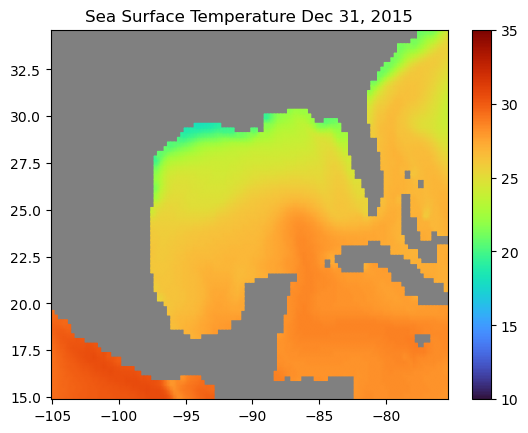

In [112]:
# loop through the data and make a plot for each day
year = 2015
for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        plot_panel(year,month,day)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [110]:
# make a list of files for each movie panel
files = [os.path.join(plot_dir, f) for f in os.listdir(plot_dir) if f.endswith('.png')]

# sort the panels
files.sort()


In [113]:
# set the frames per second
fps = 10

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(files, fps=fps)

# write the video to a file
hw_dir = '/Users/misha/School Projects/Ocean Modeling/HW3'
clip.write_videofile(os.path.join(hw_dir, 'SST_movie.mp4'))

t:   1%|          | 2/366 [13:12<40:04:34, 396.36s/it, now=None]

Moviepy - Building video /Users/misha/School Projects/Ocean Modeling/HW3/SST_movie.mp4.
Moviepy - Writing video /Users/misha/School Projects/Ocean Modeling/HW3/SST_movie.mp4



t:   1%|          | 2/366 [13:16<40:14:39, 398.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /Users/misha/School Projects/Ocean Modeling/HW3/SST_movie.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: *Enter your description here*

Some intresting observations that I mande are that the temperature on the Coast of the Gulf of Mexico hotter than the rest of the Gulf during the summer, but colder during the rest of the year. One factor that could contribute to this is that durring most of the year, there is upwelling along the coast, while during the summer there is downwelling.